# Music Genre Classification:

## Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy
import tarfile
import os
from pathlib import Path
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import subprocess
import IPython.display as ipd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import ShuffleSplit, train_test_split
from collections import defaultdict
import scikitplot
import seaborn as sns
import warnings
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

## Creating labels and FFT Features:

In [2]:
# Generating labels.
genres_labels = dict()
cnt = 0
# Loop through each class and assign a numerical value.
for folder in os.listdir("data/genres/"):
    genres_labels[folder] = cnt
    cnt += 1
    
genres_labels

{'blues': 9,
 'classical': 2,
 'country': 7,
 'disco': 3,
 'hiphop': 6,
 'jazz': 4,
 'metal': 5,
 'pop': 1,
 'reggae': 0,
 'rock': 8}

In [3]:
# Generating FFT Feature function.
def feature_class_generator(audio_file_path, class_name):
    # Read audio file from path provided
    rate, audio = wav.read(audio_file_path)
    
    # Get fft features (only top 1000)
    fft_features = np.array(abs(scipy.fft(audio)[:1000]))
    
    # Return features and label
    return fft_features, genres_labels[class_name]

In [4]:
# Getting the features corresponding to each file.

features = [] # Holds features for every wav file.
labels = [] # Holds labels for every wav file.

# Loop through each folder
for folder in os.listdir("data/genres/"):
    
    # Loop through each file
    for filename in os.listdir("data/genres/"+folder+"/"):

        # Get feaure and label for the file.
        feature, label = feature_class_generator("data/genres/"+folder+"/"+filename, folder)
        
        # Store feature and label seperatly
        features.append(feature)
        labels.append(label)
        
print(len(features))
print(len(labels))

1000
1000


In [5]:
# Create a dataframe out of features and labels, shuffle them then store them.
df = pd.DataFrame(features)
df['label'] = labels
df = shuffle(df)
df = shuffle(df)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
df.head()
df.to_pickle("FFT_Features.pkl")

In [6]:
df.shape

(1000, 1001)

In [7]:
df = pd.read_pickle("FFT_Features.pkl")
labels = df['label']
df.drop(columns = ['label'], inplace=True)
label_to_genre = ['reggae', 'pop', 'classical', 'disco', 'jazz', 'metal', 'hiphop', 'country', 'rock', 'blues']
# Randomly seperate data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size = 0.3, random_state=0) 

print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(700, 1000)
(300, 1000)
700
300


## Metric Functions:

In [8]:
# this function uses heatmap of seaborn library to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred, name):
    cm = confusion_matrix(y_test, y_pred)
    confusion_df = pd.DataFrame(data=cm, columns=label_to_genre, index=label_to_genre)
    fig1=plt.figure(figsize=(15,7))
    plt.title("Not Normalized Confusion Matrix")
    sns.heatmap(confusion_df, annot=True)
    plt.show()
    fig1.savefig(name)
    fig2=plt.figure(figsize=(15,7))
    plt.title("Normalized Confusion Matrix")
    sns.heatmap(confusion_df/confusion_df.sum(axis=1), annot=True)
    plt.show()
    fig2.savefig(name+" Normalized")

In [15]:
# this function uses the scikitplot library to plot ROC_AUC Curve.
def plot_roc_auc_curve(y_test, y_proba_pred, name):
    fig, ax = plt.subplots(figsize=(15,7))
    scikitplot.metrics.plot_roc_curve(y_test, y_proba_pred, ax=ax)
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(name, bbox_inches=extent.expanded(1.1, 1.2))

## Logistics Regression:

In [10]:
# For hyperparameter tuning.
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalty = ['l2', 'l1']

# For plotting.
xticks = []
rocauc_scores = []

for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        
        # fit / Train
        lr = LogisticRegression(multi_class='ovr',C=a,penalty=p,max_iter=10000,verbose = 1,n_jobs = -1)
        lr.fit(X_train, y_train)
        # Get log probabilities.
        y_pred = lr.predict_proba(X_test)
        
        # Calculate average ROC_AUC Score.
        score = 0
        for label in range(10):
            # Extract current label.
            y_test_label = np.asarray(y_test == label, dtype=int)
            # Calculate the roc_auc score for current class.
            score += roc_auc_score(y_test_label, y_pred[:, label]).mean()
        
        # Store the average roc_auc score.
        rocauc_scores.append(score/10)
        print(xticks[len(xticks)-1] + ": ", score/10)

[LibLinear]1e-05 l2:  0.6415600277807922
[LibLinear]1e-05 l1:  0.6406946255573385
[LibLinear]0.0001 l2:  0.6403778152988604
[LibLinear]0.0001 l1:  0.6431076160080113
[LibLinear]0.001 l2:  0.640686326642375
[LibLinear]0.001 l1:  0.6233670116095787
[LibLinear]0.01 l2:  0.6399181475174089
[LibLinear]0.01 l1:  0.6216956023901506
[LibLinear]0.1 l2:  0.6402031797600465
[LibLinear]0.1 l1:  0.627612426136844
[LibLinear]1 l2:  0.6382315587250439
[LibLinear]1 l1:  0.6328359645138353
[LibLinear]10 l2:  0.6400006822360889
[LibLinear]10 l1:  0.6412923938143471
[LibLinear]100 l2:  0.6414937697606333
[LibLinear]100 l1:  0.6627643065012851
[LibLinear]1000 l2:  0.6393314429185069
[LibLinear]1000 l1:  0.6676297898617498


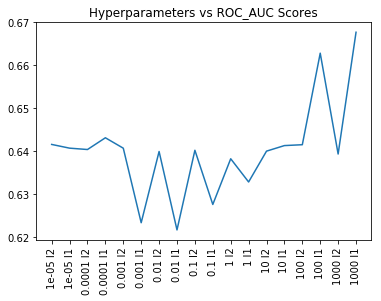

In [12]:
# Plot of Hyperparameters vs ROC_AUC Scores
fig = plt.figure()
plt.title("Hyperparameters vs ROC_AUC Scores")
plt.plot(range(len(xticks)), rocauc_scores)
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.show()
fig.savefig("LR_FFT_hyperparameters_vs_roc_auc")

In [13]:
# Training the Model with best parameters found.
C = 1000 # From graph.
p = 'l1' # From graph.
lr = LogisticRegression(C=C, penalty=p, solver='liblinear', multi_class='ovr', max_iter=10000, n_jobs = -1)
lr.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr',
          n_jobs=-1, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

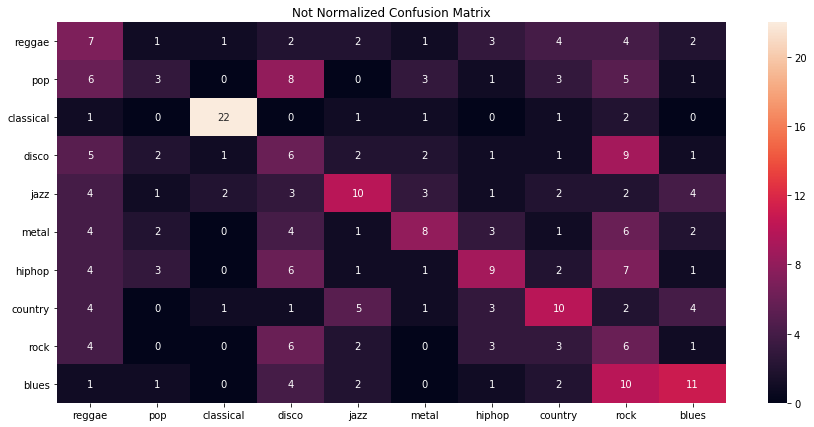

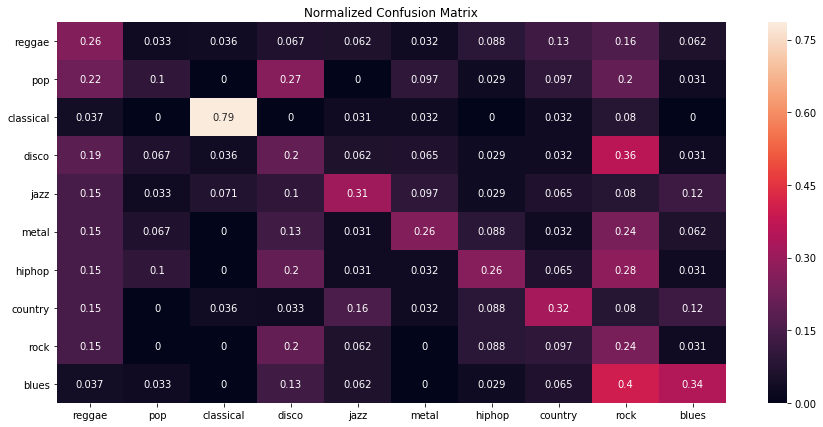

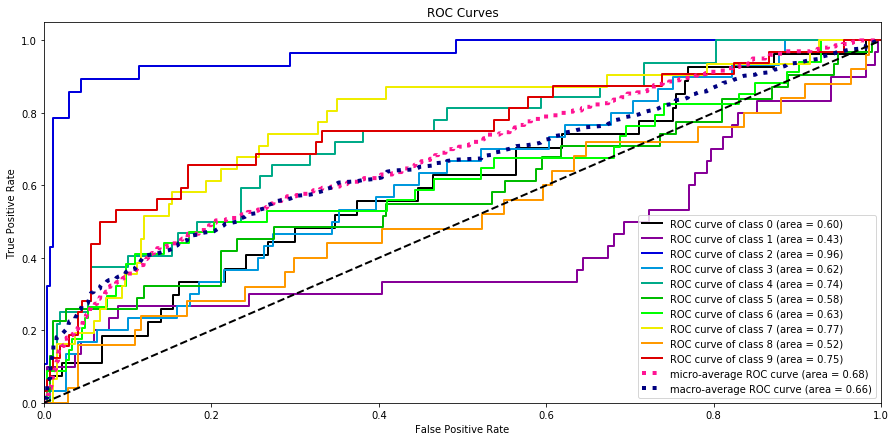

In [16]:
# Getting the confusion matrix.
y_pred = lr.predict(X_test)
y_proba_pred = lr.predict_proba(X_test)
plot_confusion_matrix(y_test, y_pred, "LR_FFT_Confusion_Matrix")
plot_roc_auc_curve(y_test, y_proba_pred, "LR_FFT_ROC_AUC_Curve")

## RandomForest:

In [17]:
# Hyperparameters:
n_estimators = [30, 50, 100, 300, 500]
max_depth = [3, 5, 7]

# For plotting.
xticks = []
rocauc_scores = []

for estim in n_estimators:
    for dep in max_depth:
        xticks.append("Estimators:" + str(estim) + ' MaxDepth:' + str(dep))
        
        # fit / Train
        rf = RandomForestClassifier(n_estimators=estim, max_depth=dep, n_jobs=-1)
        rf.fit(X_train, y_train)
        # Get log probabilities.
        y_pred = rf.predict_proba(X_test)
        
        # Calculate average ROC_AUC Score.
        score = 0
        for label in range(10):
            # Extract current label.
            y_test_label = np.asarray(y_test == label, dtype=int)
            # Calculate the roc_auc score for current class.
            score += roc_auc_score(y_test_label, y_pred[:, label]).mean()
        
        # Store the average roc_auc score.
        rocauc_scores.append(score/10)
        print(xticks[len(xticks)-1] + ": ", score/10)

Estimators:30 MaxDepth:3:  0.7690334387009208
Estimators:30 MaxDepth:5:  0.7764135094544434
Estimators:30 MaxDepth:7:  0.7839406322652294
Estimators:50 MaxDepth:3:  0.7530377618977406
Estimators:50 MaxDepth:5:  0.7856988574632535
Estimators:50 MaxDepth:7:  0.7831416781895213
Estimators:100 MaxDepth:3:  0.7636687931977125
Estimators:100 MaxDepth:5:  0.7902781962485435
Estimators:100 MaxDepth:7:  0.8033654459969078
Estimators:300 MaxDepth:3:  0.7671134559139215
Estimators:300 MaxDepth:5:  0.7923878802501432
Estimators:300 MaxDepth:7:  0.8134501387953268
Estimators:500 MaxDepth:3:  0.7677491677011117
Estimators:500 MaxDepth:5:  0.8011597140461676
Estimators:500 MaxDepth:7:  0.81356857869145


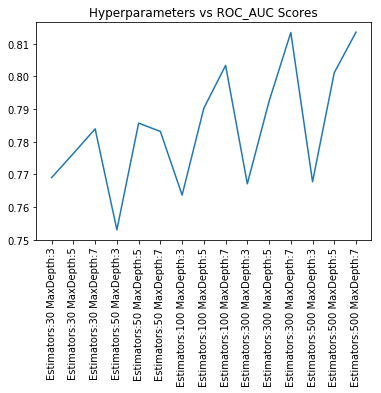

In [18]:
# Plot of Hyperparameters vs ROC_AUC Scores
fig=plt.figure()
plt.title("Hyperparameters vs ROC_AUC Scores")
plt.plot(range(len(xticks)), rocauc_scores)
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.show()
fig.savefig("RF_FFT_Hyperparameters_vs_roc_auc")

In [19]:
# Training the Model with best parameters found.
estim = 500 # From graph.
dep = 7 # From graph.
rf = RandomForestClassifier(n_estimators=estim, max_depth=dep)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

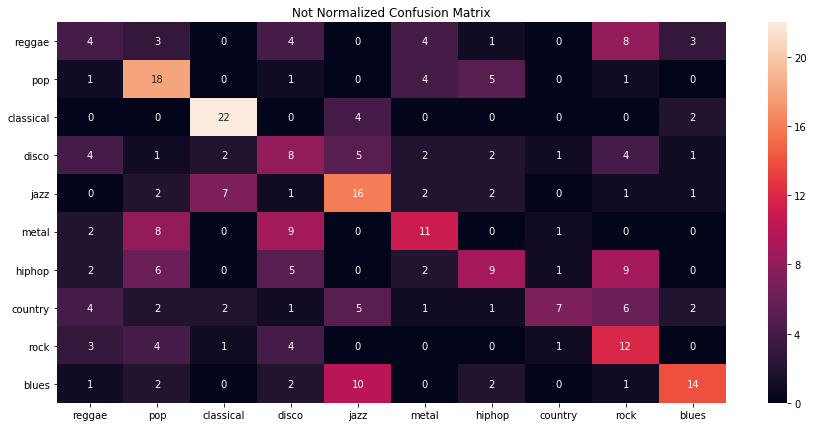

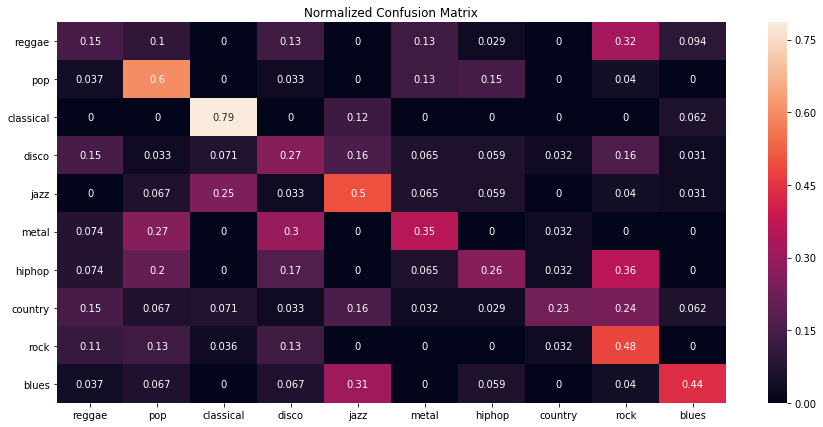

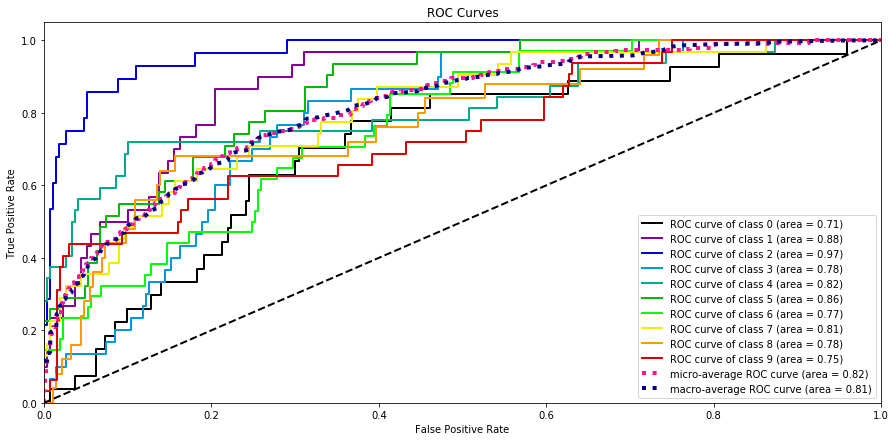

In [21]:
# Getting the confusion matrix.
y_pred = rf.predict(X_test)
y_proba_pred = rf.predict_proba(X_test)
plot_confusion_matrix(y_test, y_pred, "RF_FFT_Confusion_Matrix")
plot_roc_auc_curve(y_test, y_proba_pred, "RF_FFT_ROC_AUC_Curve")

## XGBClassifier:

In [22]:
# Hyperparameters:
n_estimators = [30, 50, 100, 300, 500]
max_depth = [3, 5, 7]

# For plotting.
xticks = []
rocauc_scores = []

for estim in n_estimators:
    for dep in max_depth:
        xticks.append("Estimators:" + str(estim) + ' MaxDepth:' + str(dep))
        
        # fit / Train
        xgbcf = XGBClassifier(n_estimators=estim, max_depth=dep, n_jobs=-1)
        xgbcf.fit(X_train, y_train)
        # Get log probabilities.
        y_pred = xgbcf.predict_proba(X_test)
        
        # Calculate average ROC_AUC Score.
        score = 0
        for label in range(10):
            # Extract current label.
            y_test_label = np.asarray(y_test == label, dtype=int)
            # Calculate the roc_auc score for current class.
            score += roc_auc_score(y_test_label, y_pred[:, label]).mean()
        
        # Store the average roc_auc score.
        rocauc_scores.append(score/10)
        print(xticks[len(xticks)-1] + ": ", score/10)

Estimators:30 MaxDepth:3:  0.8090329011136508
Estimators:30 MaxDepth:5:  0.8345397939549578
Estimators:30 MaxDepth:7:  0.8287284394257874
Estimators:50 MaxDepth:3:  0.8210010243751856
Estimators:50 MaxDepth:5:  0.8413011253024237
Estimators:50 MaxDepth:7:  0.8398161902532072
Estimators:100 MaxDepth:3:  0.8352270922030438
Estimators:100 MaxDepth:5:  0.8460237834880555
Estimators:100 MaxDepth:7:  0.8434242805276622
Estimators:300 MaxDepth:3:  0.8363393707680242
Estimators:300 MaxDepth:5:  0.8480367649058209
Estimators:300 MaxDepth:7:  0.8477973355539724
Estimators:500 MaxDepth:3:  0.8362260271706712
Estimators:500 MaxDepth:5:  0.8468932598343084
Estimators:500 MaxDepth:7:  0.8467419894215684


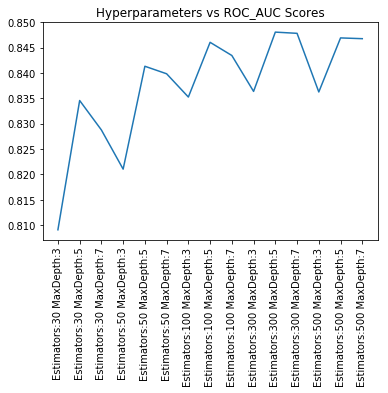

In [23]:
# Plot of Hyperparameters vs ROC_AUC Scores
fig=plt.figure()
plt.title("Hyperparameters vs ROC_AUC Scores")
plt.plot(range(len(xticks)), rocauc_scores)
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.show()
fig.savefig("XgBoost_FFT_Hyperpaameters_vs_roc_auc")

In [24]:
# Training the Model with best parameters found.
estim = 300 # From graph.
dep = 7 # From graph.
xgbcf = XGBClassifier(n_estimators=estim, max_depth=dep, n_jobs=-1)
xgbcf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

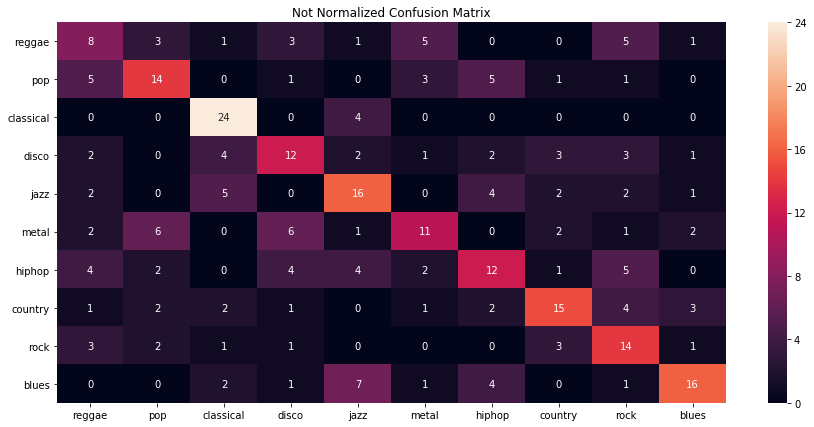

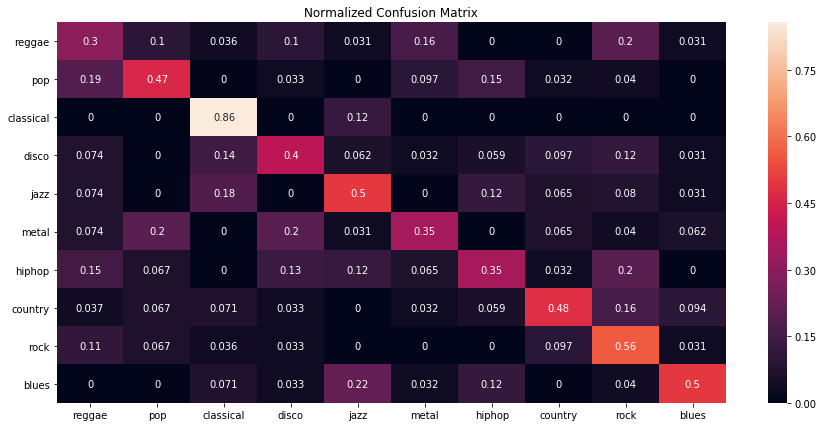

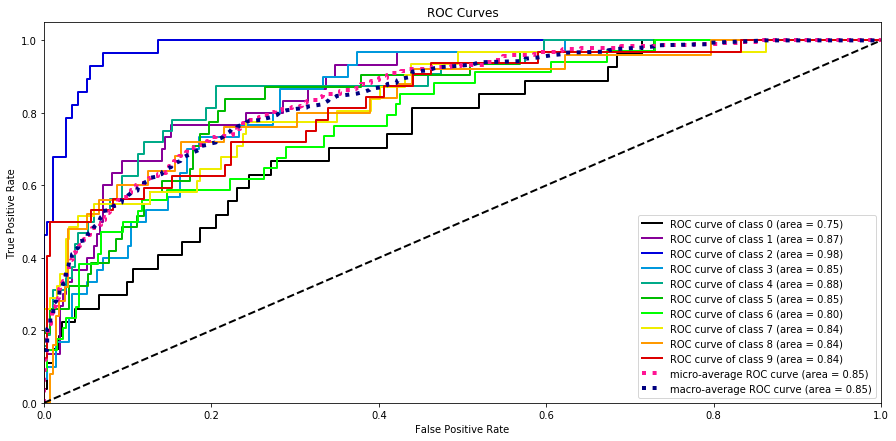

In [25]:
# Getting the confusion matrix.
y_pred = xgbcf.predict(X_test)
y_proba_pred = xgbcf.predict_proba(X_test)
plot_confusion_matrix(y_test, y_pred, "XgBoost_FFT_Confusion_Matrix")
plot_roc_auc_curve(y_test, y_proba_pred, "XgBoost_FFT_ROC_AUC_Curve")